In [51]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw6.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">



In [52]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

#### Instructions
- **THIS IS AN INDIVIDUAL ASSIGNMENT. Collaboration on this homework IS NOT PERMITTED.**
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Decision Tree [21 pts]**](#part1)


- [**Question 2: Bagging [20 pts]**](#part2) 


- [**Question 3: Random Forests [14 pts]**](#part3) 


- [**Question 4: Boosting [30 pts]**](#part4) 


- [**Question 5: Understanding [15 pts]**](#part5) 
  
  

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)


### Higgs boson discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

### Data description

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

### Loading the data

Run the following cell to load the data. Do not modify this code. We need to ensure everyone has the exact same arrays for this homework.

In [54]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

data_train = pd.read_csv("data/Higgs_train.csv")
data_test = pd.read_csv("data/Higgs_test.csv")

print(
    f"Our data contains {len(data_train):,} training samples "
    f"and {len(data_test):,} test samples.\n"
)

print("TRAINING DATA INFORMATION:\n")
data_train.info()

print("\nTRAINING DATA HEAD:")
display(data_train.head())

print("\nTRAINING DATA SUMMARY STATISTICS:")
display(data_train.describe())

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

Our data contains 5,000 training samples and 5,000 test samples.

TRAINING DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lepton pT                 5000 non-null   float64
 1   lepton eta                5000 non-null   float64
 2   lepton phi                5000 non-null   float64
 3   missing energy magnitude  5000 non-null   float64
 4   missing energy phi        5000 non-null   float64
 5   jet 1 pt                  5000 non-null   float64
 6   jet 1 eta                 5000 non-null   float64
 7   jet 1 phi                 5000 non-null   float64
 8   jet 1 b-tag               5000 non-null   float64
 9   jet 2 pt                  5000 non-null   float64
 10  jet 2 eta                 5000 non-null   float64
 11  jet 2 phi                 5000 non-null   float64
 12  jet 2 b-tag             

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0



TRAINING DATA SUMMARY STATISTICS:


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


<a id="part1"></a>

## <div class='exercise'>Question 1: Decision Tree [21 pts]</div> 
    
[Return to contents](#contents)
    

<div class='exercise-r'>

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Store the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds` respectively.
</div>

_Points:_ 7

In [55]:
# your code here

df = pd.DataFrame(columns=['depth', 'all_cv','train_scores', 'test_scores','mean_cv', 'std_cv'])

tree_depth_start, tree_depth_end, steps = 1, 20, 1

idx = 0 # index number of the dataframe df

for i in range(tree_depth_start, tree_depth_end + 1, steps):

    #declare tree model object
    model = DecisionTreeClassifier(criterion='gini', max_depth = i).fit(X_train, y_train)
    scores = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
    
    df.loc[idx, 'depth'] = i
    df.loc[idx, 'all_cv'] = scores
    # df.loc[idx, 'train_scores'] = model.score(X_train, y_train)
    df.loc[idx, 'train_scores'] = accuracy_score(y_train, model.predict(X_train))
    df.loc[idx, 'test_scores'] = accuracy_score(y_test, model.predict(X_test))
    df.loc[idx, 'mean_cv'] = scores.mean()
    df.loc[idx, 'std_cv'] = scores.std()
    
    idx += 1

train_scores = df["train_scores"].values
test_scores = df["test_scores"].values
cvmeans = df["mean_cv"].values
cvstds = df["std_cv"].values

In [56]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**1.2** Now that we have `train_scores`, `cvmeans`, and `cvstds`, let's plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.

</div>

_Points:_ 7

C:\Users\sykri\AppData\Local\Temp\ipykernel_38620\376475270.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[0].plot(tree_depth, test_scores, 'b-', c='g', alpha=0.4, marker='o')


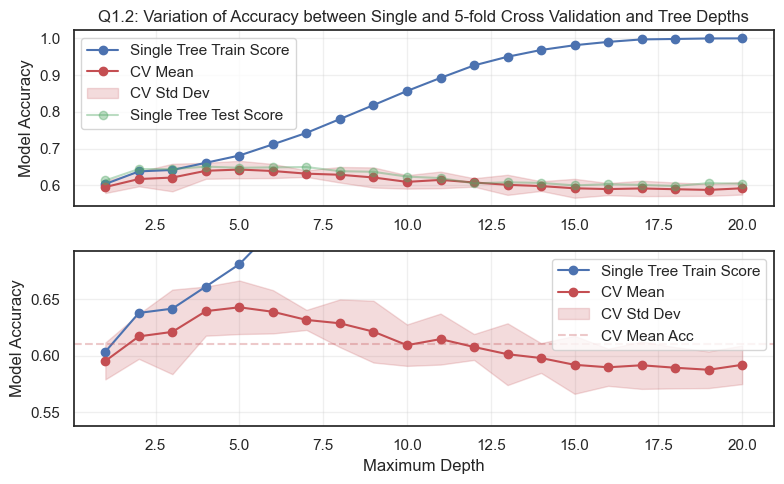

In [57]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

tree_depth =  [i for i in range(tree_depth_start, tree_depth_end + 1, steps)]
train_scores = np.array(df["train_scores"].values, dtype = float)
test_scores = np.array(df["test_scores"].values, dtype = float)
cvmeans = np.array(df["mean_cv"].values, dtype = float)
cvstds = np.array(df["std_cv"].values, dtype = float)

#Plot


axes[0].plot(tree_depth, train_scores, 'b-', marker='o')
axes[0].plot(tree_depth, cvmeans, 'r-', marker='o')
axes[0].fill_between(tree_depth, cvmeans + (cvstds*2), 
                     cvmeans - (cvstds*2), 
                     color = 'r', alpha=0.2)
axes[0].plot(tree_depth, test_scores, 'b-', c='g', alpha=0.4, marker='o')
axes[0].set_ylabel("Model Accuracy")
axes[0].set_title('Q1.2: Variation of Accuracy between Single and 5-fold Cross Validation and Tree Depths')
axes[0].legend(['Single Tree Train Score', 'CV Mean','CV Std Dev', 'Single Tree Test Score'])
axes[0].grid(alpha = 0.3)


axes[1].plot(tree_depth, train_scores, 'b-', marker='o')
axes[1].plot(tree_depth, cvmeans, 'r-', marker='o')
axes[1].fill_between(tree_depth, cvmeans + (cvstds*2), 
                     cvmeans - (cvstds*2), 
                     color = 'r', alpha=0.2)
axes[1].axhline(np.mean(cvmeans), c='r', ls='--', alpha=0.3, label=rf'Accuracy mean')
axes[1].set_ylabel("Model Accuracy")
axes[1].set_ylim(np.min(cvmeans)-0.05, np.max(cvmeans)+0.05)
axes[1].set_xlabel("Maximum Depth")
axes[1].legend(['Single Tree Train Score', 'CV Mean','CV Std Dev', 'CV Mean Acc'])
axes[1].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, store it in `best_cv_depth`, and **justify your choice**. Then, using this depth, fit a new decision tree on the entire training data and store the train and test accuracies in `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

</div>

_Points:_ 4

The criteria of `best_cv_depth` should maximize model accuracy and minimize variance.

This gives us 2 potential values -  depth of 5 or 7. Depth 5 has the highest cvmeans, but quite a large variance. Depth 7 is the 3rd highest accuracy, and has the 2nd smallest variance, where ~95% of it's predictions (2 std.dev) are accurate within <0.02 range. The tie breaker is in the lower 2 sd limit (lower region highlighted in red), where Depth = 7's lower 2 sd limit is >0.62, while Depth 5 <0.62.

Therefore, based on the 1) performance of a depth's accuracy over its mean, and 2) variance of prediction values, Depth 7 is the best chosen depth from a qualitative analysis.

In [61]:
def decision_tree_scores(depth, X_train, y_train, X_test, y_test):
    
    model = DecisionTreeClassifier(criterion='gini', max_depth = depth).fit(X_train, y_train)

    train_score = accuracy_score(y_train, model.predict(X_train))
    test_score = accuracy_score(y_test, model.predict(X_test))

    return train_score, test_score, model

In [62]:
# your code here
# choose best depth after a qualitative assessment of our plots
best_cv_depth = 7
best_cv_tree_train_score, best_cv_tree_test_score, best_tree_model = decision_tree_scores(best_cv_depth, 
                                                                        X_train, y_train,
                                                                        X_test, y_test)

In [63]:
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 7 trained on the full training set, achieves the following accuracy scores:

	train	0.7428
	TEST	0.6514


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.4** In terms of the bias-variance tradeoff, how does limiting tree depth avoid over-fitting? What is one downside of limiting the tree depth?

</div>

_Points:_ 3

Limiting tree depth could avoid overfitting - e.g leaf nodes with only one datapoint. A tree with lower depth is more robust to training data noise as the low dimentional shape carved by the model is stable (Low Variance). This prevents overfitting as the model can generalize better and not model the data noise.

The downside of limiting tree depth is that the tree might not have enough decision boundaries to model the data relationships. It cannot capture the nonlinear boundary separating classes (High Bias).

<!-- END QUESTION -->

<a id="part2"></a>

## <div class='exercise'>Question 2: Bagging [20 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

</div>

_Points:_ 3

An overfitted model predicts perfectly on the training data, but performs worse on testing data. This is due to the complex model memorizing the data noise, and failing to capture important decision boundary patterns. Looking at plot Q1.2, the max training score and min test score are at tree depth of 20. The decision tree at tree-depth = 20 performs perfectly on the training data, but has an 0.5998 accuracy on the test data. Recall that the test accuracy for best tree-depth (k=7) was 0.6512, which is >5% accuracy reduction.

In [64]:
# set overfitting tree_depth based on provided rationale 
tree_depth = 20
overfit_tree_train_score, overfit_tree_test_score, overfit_tree_model = decision_tree_scores(tree_depth, 
                                                                        X_train, y_train,
                                                                        X_test, y_test)
print(f"Re-running a decision tree with tree-depth = 20, the train and test accuracies are {overfit_tree_train_score} and {overfit_tree_test_score}, respectively.")

Re-running a decision tree with tree-depth = 20, the train and test accuracies are 1.0 and 0.601, respectively.


<!-- END QUESTION -->

<div class='exercise-r'>

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- Using a random seed of 0, call the provided `bagger` function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps are returned by the `bagger` function as dataframes formatted like the example shown below. Each row represents one observation (from either the training or test set depending on the dataframe), and each column represents one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

An example of the `bagging_train_df` and `bagging_test_df` dataframes would be:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

</div>

_Points:_ 1

In [65]:
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [66]:
# specify number of required bootrapped trees
n_trees = 55 

In [67]:
# generate predictions using bagger function
bagging_train_df, bagging_test_df, bagging_models_list = bagger(
    n_trees,
    tree_depth,
    X_train,
    y_train,
    X_test,
    0,
    )

In [68]:
# display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1
3,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1,1
1,0,1,1,0,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0
2,1,0,1,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,1,1,0,1,0,1,0
3,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,1,0


In [69]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`.

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

</div>

_Points:_ 4

In [70]:
# evaluate accuracy on our bagged prediction results
y_train_pred = np.array(bagging_train_df.apply(lambda x: 1 if np.mean(x) > 0.5 else 0, axis=1))
y_test_pred = np.array(bagging_test_df.apply(lambda x: 1 if np.mean(x) > 0.5 else 0, axis=1))
bagging_accuracy_train = accuracy_score(y_train, y_train_pred)
bagging_accuracy_test = accuracy_score(y_test, y_test_pred)

In [71]:
# print summary of results
print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"TEST score of {best_cv_tree_test_score:.4f}."
)

Bagging 55 trees of depth-20 achieves the following accuracy scores:

	train	0.9998
	TEST	0.6846

Our prior single depth-7 tree achieved a TEST score of 0.6514.


In [72]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.

</div>

_Points:_ 7

In [73]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

def running_predictions(
    bagger_results_df: pd.DataFrame,
    targets: np.ndarray,
) -> pd.Series:
    """Generates running accuracy of intermediate bootstraps when bagging 
    
    Generates a series of accuracy scores calculated using the
    running predictions of each additional bootstrapped model
    generated using the Question 2.2 `bagger` function. For example,
    the first accuracy in the series represents the predictive
    accuracy of just the first bootstrapped model. The second accuracy
    reflects the bagged accuracy of the first 2 bootstrapped models. The
    j-th accuracy reflects the bagged accuracy of the first j
    bootstrapped models.
    
    :param bagger_results_df: pd.DataFrame, a bagging results dataframe
                              (either train or test) output from the Q2.2
                              `bagger` function
    :param targets: np.ndarray, 1-dimensional array of true class labels
                    for either train or test observations (i.e y_train or
                    y_test, whichever corresponds to the inputted
                    bagger_results_df)             
    :returns: pd.Series, a series of values showing the accuracy of
              using the initial j trees to predict the targets for each
              value of j bootstrapped models
    """
    # verify that input data objects meet the requirements specified
    # in the docstring
    assert type(bagger_results_df)==pd.core.frame.DataFrame, (
        "bagger_results_df input must be a pd.DataFrame"
    )
    assert type(targets)==np.ndarray, (
        "targets input must be an np.ndarray"
    )
    assert targets.ndim==1, (
        "targets input np.ndarray must be one-dimensional"
    )
    
    # identify the number of bootstrapped trees in inputted bagger df
    n_trees = bagger_results_df.shape[1]
    
    # calculate the running percentage of models voting 1 as each
    # additional model is considered
    running_percent_1s = (
        np.cumsum(bagger_results_df, axis=1)/np.arange(1,n_trees+1)
    )
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    # calculate and return final accuracies
    return np.mean(running_correctnesss, axis=0)


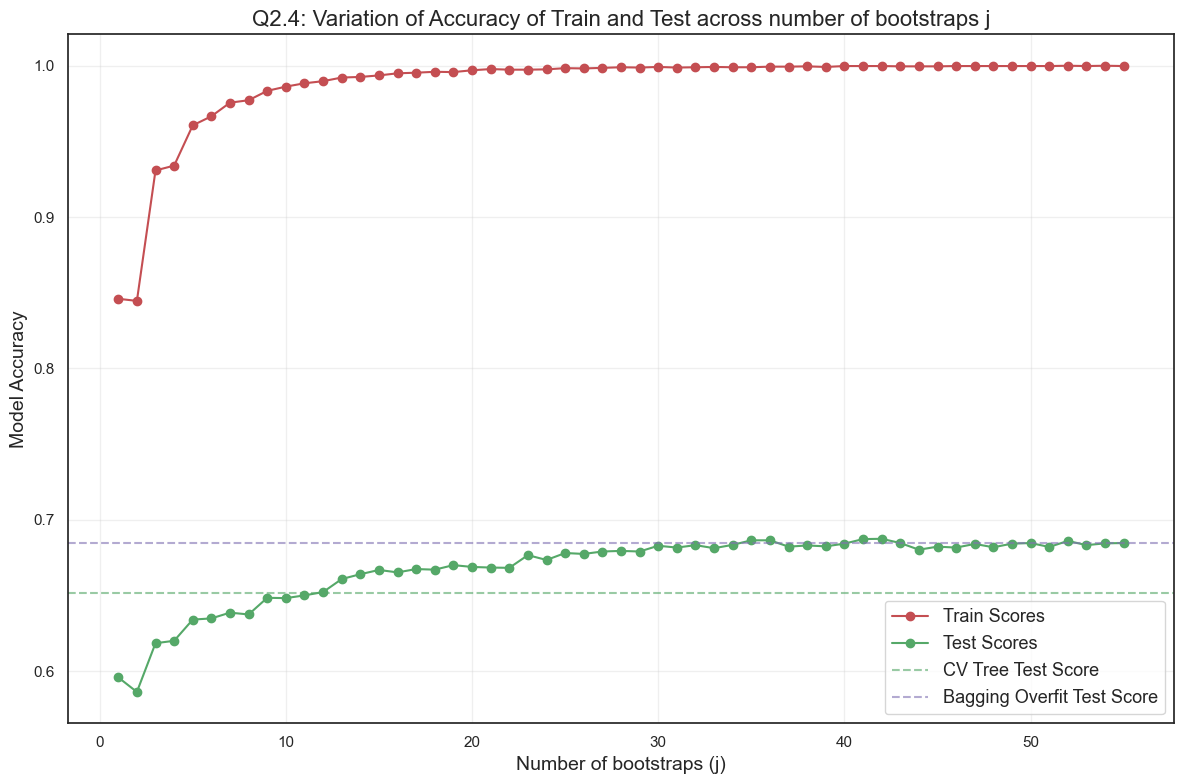

In [74]:
n_boots =  [i for i in range(1, n_trees+1)]
train_scores = running_predictions(bagging_train_df, y_train)
test_scores = running_predictions(bagging_test_df, y_test)

#Plot
plt.figure(figsize=(12,8))
plt.plot(n_boots, train_scores, c='r', marker='o')
plt.plot(n_boots, test_scores, c='g', marker='o')
plt.title('Q2.4: Variation of Accuracy of Train and Test across number of bootstraps j', fontsize=16)

plt.axhline(best_cv_tree_test_score, c='g', ls='--', alpha=0.6, label=rf'Q1 Test Score')
plt.axhline(bagging_accuracy_test, c='m', ls='--', alpha=0.6, label=rf'Q2.1 Test Score')

plt.legend(['Train Scores', "Test Scores","CV Tree Test Score","Bagging Overfit Test Score"], fontsize=13)
plt.ylabel("Model Accuracy", fontsize=14)
plt.xlabel("Number of bootstraps (j)", fontsize=14)
plt.grid(alpha = 0.3)

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain what you see in terms of the differences between how bagging and limiting tree depth work to control overfitting.

</div>

_Points:_ 5

At an ideal range of boostraps, bagging with overfit tree depth = 20 outperforms a single "optimally" chosen tree_depth of 7. Bagging at n_boostraps = ~10 performed equally as good as single CV Tree at depth = 7. Bagging's performance peaks at n_bootstrap ~35 and plateaus.

limiting tree depth controls overfitting by reducing the tree's sensitivity to data noise (perturbations), at the cost of reduced accuracy by being unable to optimally capture the nonlinear boundaries.

Additionally, bagging also controls overfitting by taking 1) bootstrap sampling and 2) taking consensus of bootstraps. Increasing number of bootstraps increases test accuracy, but up to a point. As shown in Q2.1, a single overfit tree of depth = 20 has the worst test accuracy of ~0.6, but bagging 'generalized' these overfitted tree models into a more robust model. Taking consensus of predictions also reduces overfitting by reducing the effect of outliers, as these outliers end up in few 'bags' during bootstrapping.


<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Random Forests [14 pts]</div> 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate classifier's accuracy on the training and test sets and store them in `random_forest_train_score` and `random_forest_test_score`.

</div>

_Points:_ 3

In [75]:
random_forest = RandomForestClassifier(max_depth=tree_depth, 
                                    random_state=0,
                                    max_features=round(np.sqrt(len(data_train.columns) - 1)), 
                                    n_estimators=n_trees)

# Fit the model on the training set

random_forest.fit(X_train, y_train)

# evaluate accuracy on our bagged prediction results
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

In [76]:
# evaluate results
random_forest_train_score = round(accuracy_score(y_train_pred, y_train),4)
random_forest_test_score = round(accuracy_score(y_test_pred, y_test),4)

In [77]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-20 and 55 trees achieves the following accuracy scores:

	train	1.0000
	TEST	0.6922


In [78]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series Dataframes called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
    
**IMPORTANT:** As always, your output should be easy to interpret. In this context that means construcing your DataFrames with the care, assigning appropriate column names and/or index values to best convey to the reader what the output represents.

</div>

_Points:_ 6

The drawback of bagging is that the algorithm creates n_trees that are highly similar, especially if there are really important predictor. To counteract this, Random Forest randomly chooses a set of predictors to consider at each split, this reduces the effect of strong predictors, and creates n_trees with low correlation to each other, which reduces bias.

This is observed in Bagging Top Predictors, where `m_bb` is the only top feature in all trees. Where as in Random Forest Top Predictors, `m_bb` is still the majority of top predictors across n_trees, but there are other features chosen as top predictors as well such as `m_wwbb` and `m_wbb`.

Random Forest's random feature selection feature introduces a layer of randomness, which prevents overfitting and bias towards extremely stron predictors. This in turn de-correlates the n_trees, and creates a more diverse forest of trees, which include more diverse set of predictors in arriving at predictions.

In [79]:
headers=data_train.iloc[:, data_train.columns != "class"].columns

In [80]:
idx=[i for i in range(1,55+1)]
df_trees = pd.DataFrame(idx, columns=["# Trees (j)"])
df_rf = pd.DataFrame(idx, columns=["# Trees (j)"])
df_trees["Bagging Top Predictors"] = pd.DataFrame([headers[model.tree_.feature[0]] for model in bagging_models_list])
df_rf["Random Forest Top Predictors"] = pd.DataFrame([headers[model.tree_.feature[0]] for model in random_forest.estimators_])

In [81]:
display(df_trees)
display(df_rf)

,# Trees (j),Bagging Top Predictors
0,1,m_bb
1,2,m_bb
2,3,m_bb
3,4,m_bb
4,5,m_bb
5,6,m_bb
6,7,m_bb
7,8,m_bb
8,9,m_bb
9,10,m_bb


,# Trees (j),Random Forest Top Predictors
0,1,m_wwbb
1,2,m_bb
2,3,m_jlv
3,4,m_wbb
4,5,m_wwbb
5,6,m_jlv
6,7,jet 2 eta
7,8,lepton pT
8,9,jet 4 phi
9,10,m_jjj


In [82]:
# Count frequencies of top predictors in random forest
top_p = list(df_rf["Random Forest Top Predictors"].unique())
p_counts = []
for p in top_p:
    p_counts.append(list(df_rf["Random Forest Top Predictors"]).count(p))

pd.DataFrame(zip(top_p, p_counts), columns=["Top Predictors", "Frequency across RF (n_trees = 55)"])


,Top Predictors,Frequency across RF (n_trees = 55)
0,m_wwbb,9
1,m_bb,10
2,m_jlv,6
3,m_wbb,8
4,jet 2 eta,1
5,lepton pT,4
6,jet 4 phi,1
7,m_jjj,7
8,missing energy magnitude,2
9,jet 2 b-tag,2


In [83]:
# your code here
top_predictors_bagging= df_trees
top_predictors_rf = df_rf

In [84]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.3**: Make a Pandas DataFrame (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |

</div>

_Points:_ 5

The train accuracies of best-depth tree is lower than its overfit counterpart, which is expected. It is unexpected as to how RF's training accuracy is higher than bagging. It is expected for RF's train accuracy to be lower than bagging, as RF's random feature selection should help reduce overfitting. However, this could be because of the un-optimized tree depth of 20.

The test accuracies of all methods are expected, where RF > bagging > best-depth tree > overfit tree. Overall, ensemble methods (bagging and RF) perform better than single trees.

In [87]:
# your code here
results_df = pd.DataFrame({"classifier": ["single depth-$i$ tree chosen by CV","single overfit depth-$k$ tree","bagging 55 depth-$k$ trees","random forest of 55 depth-$k$ trees"]})
results_df["training accuracy"] = pd.DataFrame([best_cv_tree_train_score, overfit_tree_train_score, bagging_accuracy_train, random_forest_train_score])
results_df["test accuracy"] = pd.DataFrame([best_cv_tree_test_score, overfit_tree_test_score, bagging_accuracy_test, random_forest_test_score])

In [88]:
# display results
results_df

,classifier,training accuracy,test accuracy
0,single depth-$i$ tree chosen by CV,0.7428,0.6514
1,single overfit depth-$k$ tree,1.0000,0.6010
2,bagging 55 depth-$k$ trees,0.9998,0.6846
3,random forest of 55 depth-$k$ trees,1.0000,0.6922


<!-- END QUESTION -->

<a id="part4"></a>

## <div class='exercise'>Question 4: Boosting [30 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.1** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

</div>

_Points:_ 7

In [89]:
# RUN THIS CELL
# "Attempted" boosting implementation

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


*Functionality Errors*
1) The function specifies an input boostmeup(X, y), but instead, X_train and X_test was directly called during accuracy calculations. This function might break if there are 2 instances of X_train with different data. The suggested fix would be setting input as boostmeup(X_train, X_test, y_train, y_test), and no other external variables are 
called except the ones specified as input for the function.
2) The tree1 accuracy calculation is incorrect. It should be # of correct classifications/total classifications. Instead, the code is calculating # of INCORRECT classifications/total. q should be incremented by 1 every time tree1.predict([X_train[idx]]) == y_train[idx] to obtain the correct tree1 accuray.
3) In # Train, it is incorrectly scoring 1 to a misclassification. It should be incrementing 1 to every time m > 0.5 and y_train[idx] == True.
4) The conditionals to predict test data is referring to the train data, when it should be `y_test[idx]`
5) NOt only that the calculation methods were wrong, the output for both train and tested were unclearly labeled


*Stylistic Errors*
1) Calculations for train and test accuracy is inefficient. It could be condensed into a single function, called twice. The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
2) Non-standardized indentation of the first 'if' condition, within the first for loop. It is 6 spaces away instead of 4.
3) The function name `boostmeup` is not meaningful
4) It is inefficient to loop through dataframes, pandas allow for one-liner transformation and conditional item counting.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.1:

- Write an **excellent** example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

</div>

_Points:_ 8

The intended functionality (i.e. expected requirements) of this "simplified" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

In [90]:
# your code here
def simple_boosting_pred(X, trees):
    mean_pred_proba = sum(tree.predict_proba(X)[:, 1] for tree in trees) / len(trees)
    binary_pred = (mean_pred_proba > 0.5).astype(int)
    return binary_pred

def simple_boosting_tree(X_train, X_test, y_train, y_test, max_depth):
    result_dict = {'Train Acc': [], 'Test Acc': []} 

    # Fit an initial tree with a maximum depth of 3.
    tree1 = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)

    # Predict X_train from tree1
    tree1_train_preds = simple_boosting_pred(X_train, [tree1])

    tree1_train_acc, tree1_test_acc = tree1.score(X_train, y_train), tree1.score(X_test, y_test)
    print(f"model tree1 is train_acc = {tree1_train_acc} and test_acc = {tree1_test_acc}")

    # Construct arr sample weights of 1 and 2 to samples that the initial tree classified correctly and misclassified.
    sample_weight = np.where(tree1_train_preds == y_train, 1.0, 2.0)

    # Fit the new weak classifier
    tree2 = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train, sample_weight=sample_weight)

    trees = [tree1, tree2]
    trees_train_preds = simple_boosting_pred(X_train, trees)
    trees_test_preds = simple_boosting_pred(X_test, trees)
    trees_train_acc = (trees_train_preds == y_train).sum() / len(y_train)
    trees_test_acc = (trees_test_preds == y_test).sum() / len(y_test)
    print(f"model trees is train_acc = {trees_train_acc} and test_acc = {trees_test_acc}")
    
simple_boosting_tree(X_train, X_test, y_train, y_test, 3)

model tree1 is train_acc = 0.6418 and test_acc = 0.6442
model trees is train_acc = 0.6488 and test_acc = 0.651


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** Now, let us use the scikit-learn implementation of AdaBoost. For the sake of simplicity we'll use a single validation split for hyperparameter tuning.
    
Use `AdaBoostClassifier` to fit another ensemble to the reduced training set, `X_train80`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and validation accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

</div>

_Points:_ 3

In [91]:
# Create a train/validation split for hyperparameter tuning
X_train80, X_val, y_train80, y_val = train_test_split(X_train,
                                                      y_train,
                                                      train_size=.8,
                                                      random_state=109,
                                                      stratify=y_train)

In [92]:
# your code here
adaboost_model_80 = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(max_depth=3), 
    n_estimators=800, 
    learning_rate=0.05
).fit(X_train80, y_train80)

train_staged_scores = [s for s in adaboost_model_80.staged_score(X_train80, y_train80)]
test_staged_scores = [s for s in adaboost_model_80.staged_score(X_val, y_val)]


In [93]:

result_df = pd.DataFrame(zip(train_staged_scores, test_staged_scores), columns=["Train Acc", "Test Acc"])
result_df.index =  ['Iteration ' + str(i) for i in range(1, 800 + 1)]
result_df

,Train Acc,Test Acc
Iteration 1,0.64425,0.609
Iteration 2,0.64950,0.636
Iteration 3,0.65475,0.642
Iteration 4,0.65575,0.638
Iteration 5,0.67000,0.660
...,...,...
Iteration 796,0.92600,0.661
Iteration 797,0.92600,0.661
Iteration 798,0.92600,0.661
Iteration 799,0.92600,0.660


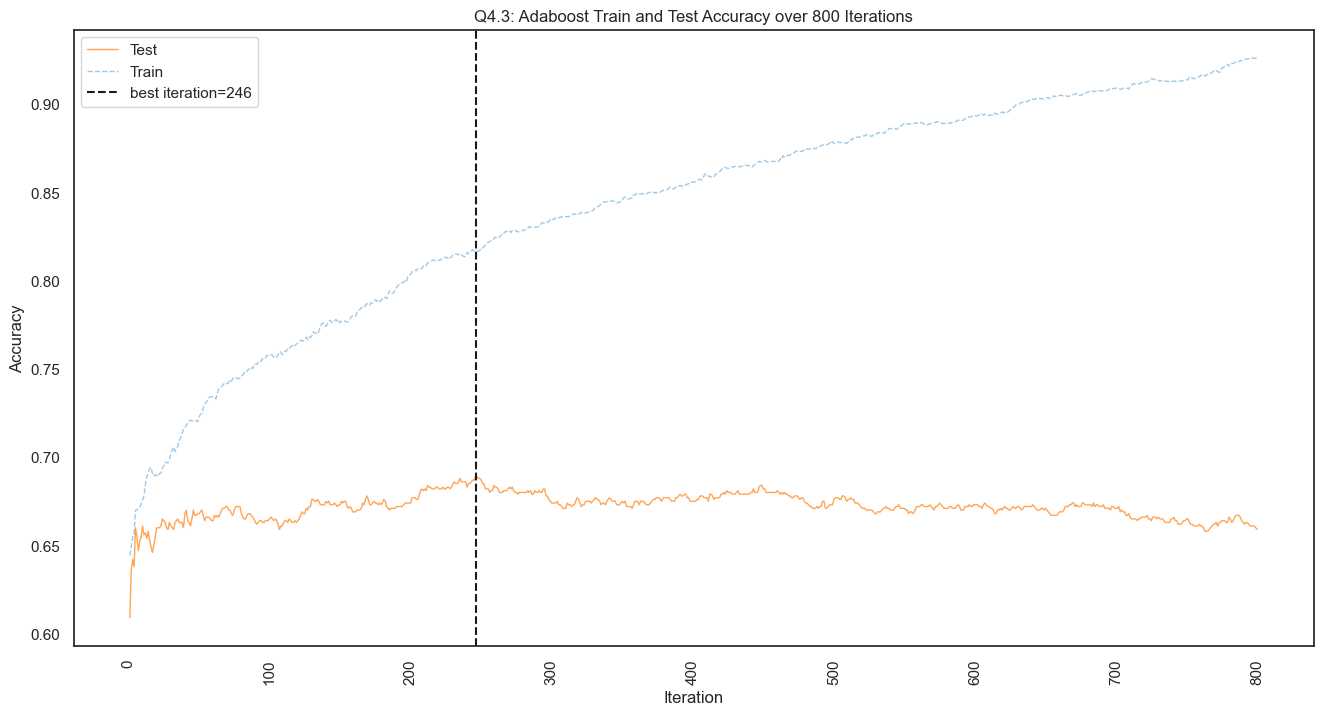

In [94]:
# your code here
plt.figure(figsize=(16,8))
def plot_acc_vs(df, attr):
    plt.plot(
        df[attr], df['Test Acc'], 
        "-",
        label="Test",
        markeredgecolor="k",
        color="tab:orange",
        alpha=0.7,
        linewidth=1
    )
    plt.plot(
        df[attr], df['Train Acc'], 
        "--",
        label="Train",
        color="tab:blue",
        alpha=0.4,
        linewidth=1
    )
    plt.legend()
    plt.xlabel(attr)
    plt.ylabel('Accuracy')
    plt.xticks(rotation=90)

# get best iteration values
best_idx = np.argmax(test_staged_scores)
best_iter = best_idx+1
best_iter

# plot Accuracy vs Iteration
plot_df = result_df.copy()
plot_df['Iteration'] = np.arange(1, len(plot_df) + 1)
plot_acc_vs(plot_df, 'Iteration')
plt.axvline(best_iter, c='k', ls='--', label=rf'best iteration={best_iter}')
plt.legend()
plt.title('Q4.3: Adaboost Train and Test Accuracy over 800 Iterations')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.4** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. For easier comparison you should arrange your plots in a row. What trends do you see in the training and validation accuracies and how would you explain this behavior?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

</div>

_Points:_ 4

As depths for the base learner increases, it seems like the max train accuracy at 800 iterations approach 1. At the same time, the best # of iterations - corresponding to the best test accuracy - gradually lowers. Both observations can be explained by the idea that higher tree depths learn and model the data faster at every iteration; it takes less time to reach 'convergence'.

Another observation is that the gap between train and test accuracies widen as tree depth increases. More accurately, train accuracy at max iteration = 800 is closer to 1. This proves the idea that boosting, at high enough iterations, can lead to overfitting, where the model perfectly classifies training data, but performs worst on the test data.

Looking at the table ion Q4.5 - comparing the best val accuracy and best iteration at every tree depth - the best val accuracy increases from tree depth = 1, peaks at tree depth = 2, and decreases at tree depths 3 and 4. THis obsevation is explained by representing tree depth as learning rates. Small learning rates may take to long to reach optimum, hence why it's best val acc is at iteration = ~650. Large learning rates (tree depth) has best val accuracies at lower iterations, but may 'bounce' around the optimum and never get sufficiently close.

In [95]:
# your code here
def fit_adaboost(depth, X_train, X_test, y_train, y_test):
    adaboost_model = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(max_depth=depth), 
    n_estimators=800, 
    learning_rate=0.05
    ).fit(X_train, y_train)

    train_staged_scores = [s for s in adaboost_model.staged_score(X_train, y_train)]
    test_staged_scores = [s for s in adaboost_model.staged_score(X_test, y_test)]

    result_df = pd.DataFrame(zip(train_staged_scores, test_staged_scores), columns=["Train Acc", "Test Acc"])
    result_df.index =  ['Iteration ' + str(i) for i in range(1, 800 + 1)]
    
    return result_df

In [96]:
results = []
for i in range(1,5):
    results.append(fit_adaboost(i, X_train80, X_val, y_train80, y_val))

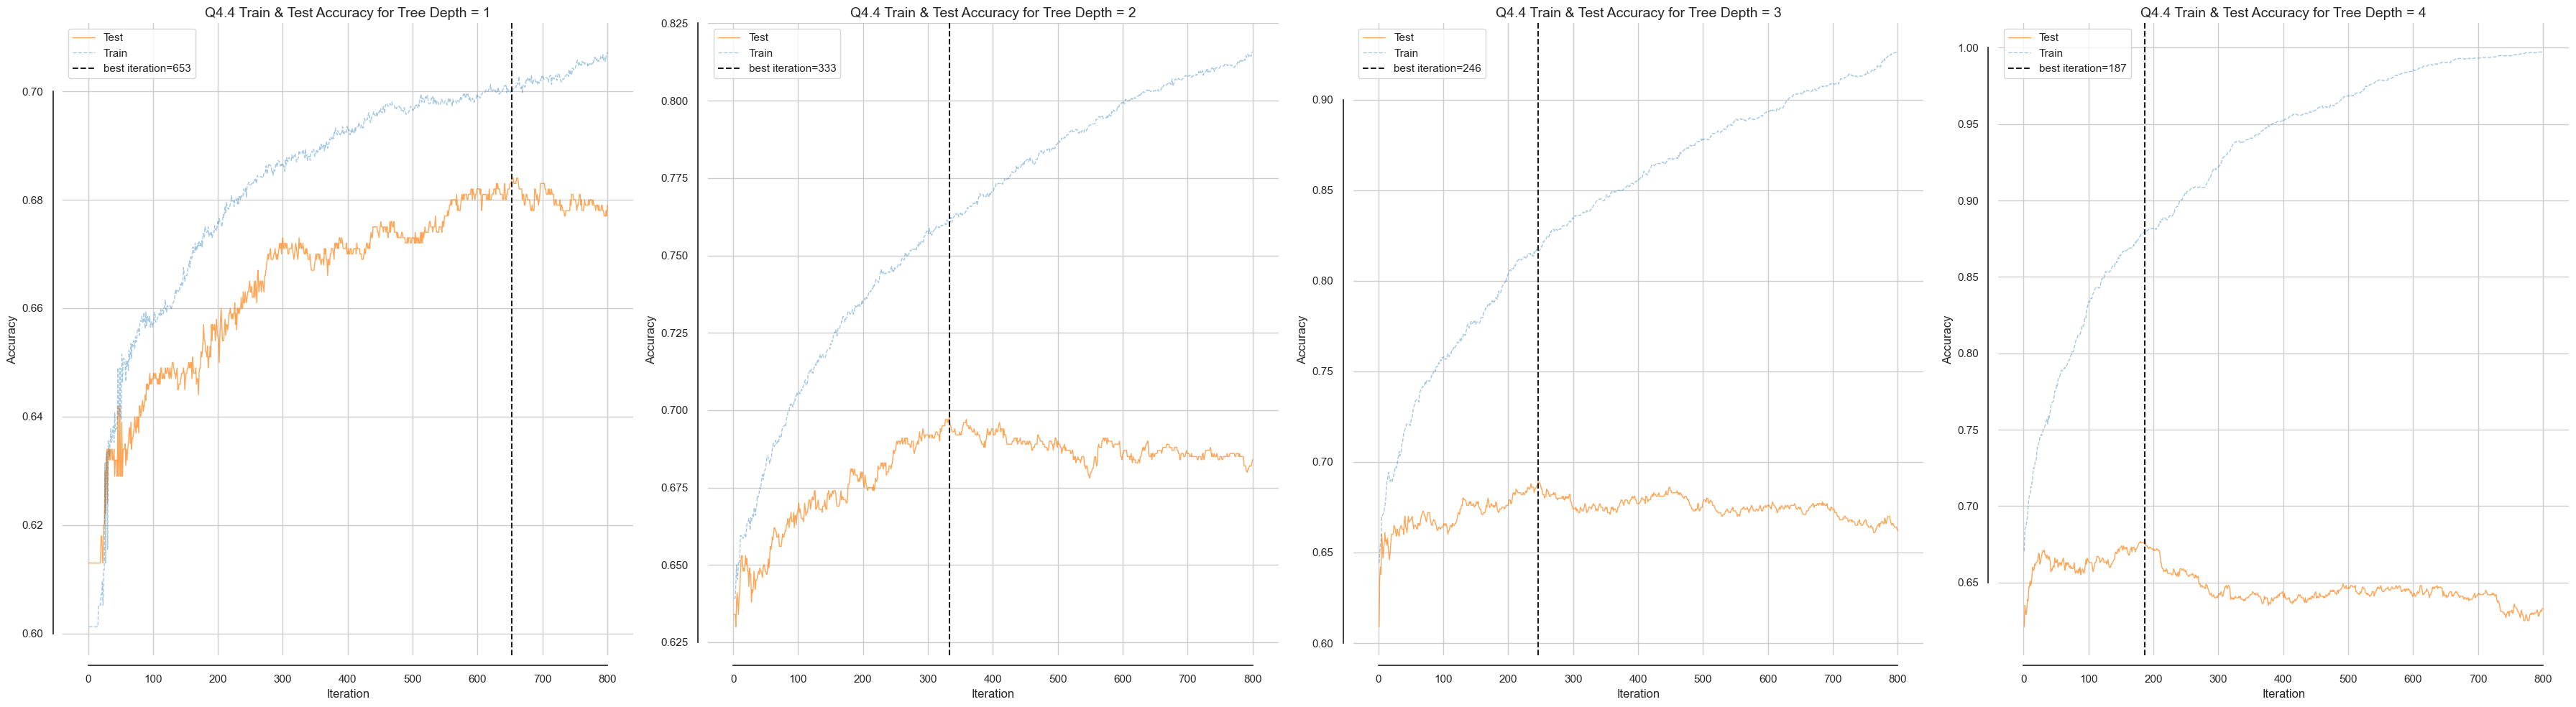

In [97]:
# your code here
fig, ax = plt.subplots(1,4,figsize=(36,10))
ax = ax.ravel()
sns.set(style="white", color_codes=True)

for i in range(len(ax)):
    plot_df = results[i]
    # get best iteration values
    best_idx = np.argmax(plot_df["Test Acc"])
    best_iter = best_idx+1
    # plot Accuracy vs Iteration
    plot_df['Iteration'] = np.arange(1, len(plot_df) + 1)

    plt.sca(ax[i])
    plot_acc_vs(plot_df, 'Iteration')
    plt.axvline(best_iter, c='k', ls='--', label=rf'best iteration={best_iter}')
    plt.legend()
    plt.grid()
    plt.title(f'Q4.4 Train & Test Accuracy for Tree Depth = {i+1}', fontsize=14)

sns.despine(offset=10, trim=True);
plt.tight_layout() 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.5** Based on the plots from Question 4.4, what combination of base learner depth and the number of iterations seems optimal and why?

**Note:** Feel free to make use of additional code to make your decision here if that is helpful. 
</div>

_Points:_ 3

The optimal tree depth has to be high enough that it reaches the optimum, but low enough not too 'bounce' around and fail to converge at the global maximum. From Question 4.4, the most optimal base learner depth and number of iterations can be determined by the max val accuracy across tree depths, which the table and output below attempts to achieve. Depths 3 and 4 are too large, which resulted in a lower best val accuracy than tree depth = 2.

In [98]:
# your code here
#  Table to observe best Val Acc at every tree depth
best_acc, best_iter = [], []
for df in results:
    best_acc.append(np.max(df["Test Acc"]))
    best_iter.append(np.argmax(df["Test Acc"]) + 1)

depths = [1,2,3,4]
depths_df = pd.DataFrame(zip(depths, best_acc, best_iter), columns=["Tree Depth (k)", "Best Val Acc", "Best Val Iteration"])

best_idx = np.argmax(depths_df["Best Val Acc"])
best_depth = depths_df["Tree Depth (k)"].loc[best_idx]
best_iter =  depths_df["Best Val Iteration"].loc[best_idx]

print(f"The optimal number of iterations are {best_iter} at a base learner depth of {best_depth}")

The optimal number of iterations are 333 at a base learner depth of 2


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.6** Fit a final AdaBoostClassifier on the **entire train set** using the base learner depth and number of iterations you identified as optimal in the previous question. Keep the learning rate at 0.05 as before. Store the train and test accuracies in `ada_train_acc` and `ada_test_acc` respectively. How does the performance of this model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?

</div>

_Points:_ 5

So far, AdaBoost with the optimal base learner depth and number of iterations is comparable to the ensemble methods in question 2 (bagging) and 3 (random forest) - Shown in table below. Its training accuracy is not as close to one as bagging and random forest, suggesting non-overfitted trees in the model. Despite not scoring perfectly in the training data, the adaboost model generalized the test data better than bagging, but not random forest.

In [45]:
# your code here
adaboost_model_full = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(max_depth=best_depth), 
    n_estimators=best_iter, 
    learning_rate=0.05
).fit(X_train80, y_train80)

train_staged_scores = [s for s in adaboost_model_full.staged_score(X_train, y_train)]
test_staged_scores = [s for s in adaboost_model_full.staged_score(X_test, y_test)]

y_pred_train = adaboost_model_full.predict(X_train)
y_pred_test = adaboost_model_full.predict(X_test)

ada_train_acc = accuracy_score(y_train, y_pred_train)
ada_test_acc = accuracy_score(y_test, y_pred_test)

In [46]:
print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

Ada Boost Train Accuracy: 74.82%
Ada Boost Test Accuracy: 68.56%


In [47]:
# your code here
results_df = pd.DataFrame({"classifier": ["single depth-$i$ tree chosen by CV","single overfit depth-$k$ tree","bagging 55 depth-$k$ trees","random forest of 55 depth-$k$ trees", "AdaBoost with Best depth and iteration"]})
results_df["training accuracy"] = pd.DataFrame([best_cv_tree_train_score, overfit_tree_train_score, bagging_accuracy_train, random_forest_train_score, ada_train_acc])
results_df["test accuracy"] = pd.DataFrame([best_cv_tree_test_score, overfit_tree_test_score, bagging_accuracy_test, random_forest_test_score, ada_test_acc])
results_df

,classifier,training accuracy,test accuracy
0,single depth-$i$ tree chosen by CV,0.7428,0.6510
1,single overfit depth-$k$ tree,1.0000,0.5968
2,bagging 55 depth-$k$ trees,0.9998,0.6846
3,random forest of 55 depth-$k$ trees,1.0000,0.6922
4,AdaBoost with Best depth and iteration,0.7482,0.6856


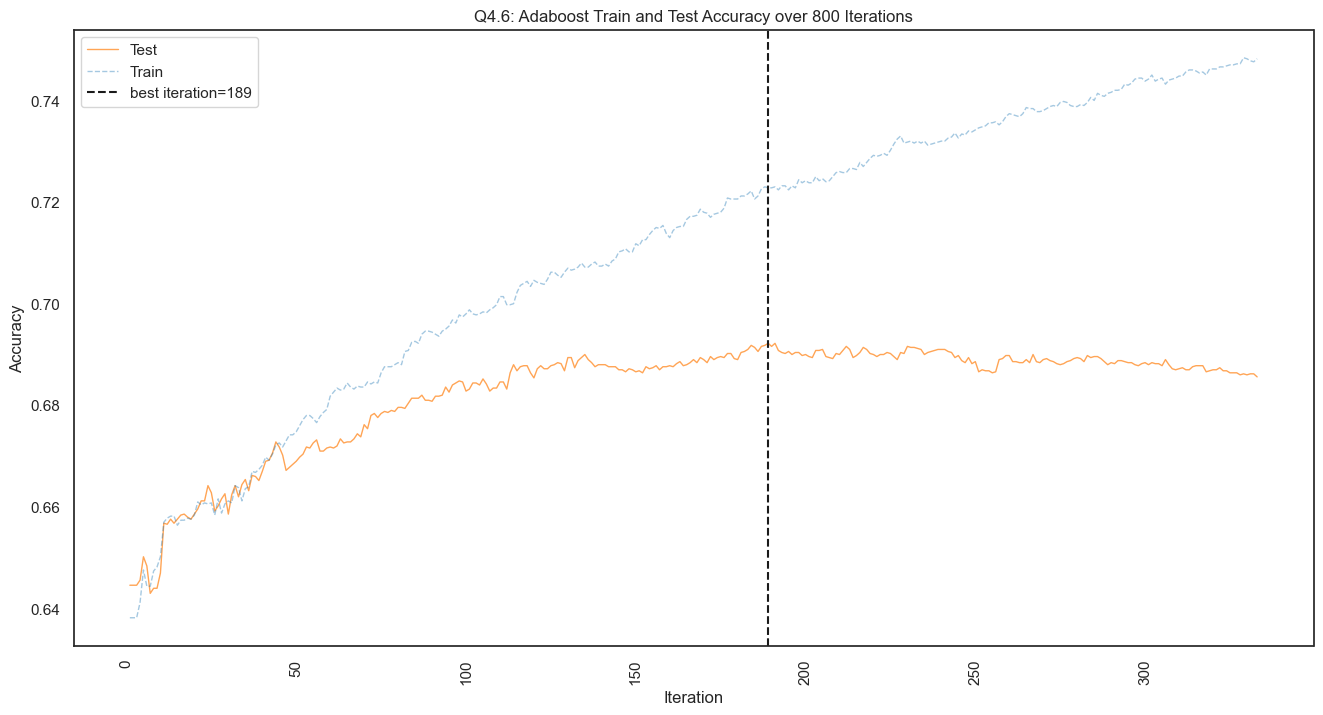

In [48]:
result_df = pd.DataFrame(zip(train_staged_scores, test_staged_scores), columns=["Train Acc", "Test Acc"])
result_df.index =  ['Iteration ' + str(i) for i in range(1, len(result_df)+1)]

# your code here
plt.figure(figsize=(16,8))
def plot_acc_vs(df, attr):
    plt.plot(
        df[attr], df['Test Acc'], 
        "-",
        label="Test",
        markeredgecolor="k",
        color="tab:orange",
        alpha=0.7,
        linewidth=1
    )
    plt.plot(
        df[attr], df['Train Acc'], 
        "--",
        label="Train",
        color="tab:blue",
        alpha=0.4,
        linewidth=1
    )
    plt.legend()
    plt.xlabel(attr)
    plt.ylabel('Accuracy')
    plt.xticks(rotation=90)

# get best iteration values
best_idx = np.argmax(test_staged_scores)
best_iter = best_idx+1
best_iter

# plot Accuracy vs Iteration
plot_df = result_df.copy()
plot_df['Iteration'] = np.arange(1, len(plot_df) + 1)
plot_acc_vs(plot_df, 'Iteration')
plt.axvline(best_iter, c='k', ls='--', label=rf'best iteration={best_iter}')
plt.legend()
plt.title('Q4.6: Adaboost Train and Test Accuracy over 800 Iterations')
plt.show()

<!-- END QUESTION -->

<a id="part5"></a>

## <div class='exercise'>Question 5: Understanding [15 pts]</div> 

[Return to contents](#contents)

This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other course materials to answer these questions.
    

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

</div>

_Points:_ 5

Boosting and bagging are both ensemble techniques that combine seevraln base models to produce an optimal predictive model. In both bagging and boosting, a set of weak learners (e.g decision trees) to create a stronger learner than a single decision tree. Both methods arrive at the final predictions by averaging all model predictions. Fromm this, both models reduce variance, reduce errors, and increase stability. 

The major drawbnack that both methods share is that it is not easy to interpret, as the model does not output a clear 'logic' to predicting from datapoints. The complex nature of these methods also mean taht they're computationally expensive than simpler models (e.g single trees, linear regression) 

A drawback unique to bagging is that trees tend to be highly correlated - extremely strong predictors will more likely stand out within a group of weak and moderate predictors. The greedy nature of bagging would bias on these strong predictors on early splits. A drawback unique to boosting is that it is more affected by outliers - the final model will be iteratively trained by the outliers. Bagging suppreses effect of outliers because the outliers are isolated in a few bags.

A unique difference is that boosting methods are built iteratively while bagging builds trees in parallel. In boosting, a weak estimator is iteratively added to an ensemble after fitting on the residuals of a parent estimator. In bagging, the trees are built independently and in parallel of each other.

Another unique difference is that bagging weak lerners can be trees with deeper depths, unlike boosting weak learners, which are shorter trees. Taking the aaverage predictions for all models in bagging has the benefit of high expressiveness - deeper trees equate to high resolution for complex decision boundaries, yet with low variance, assuming an adequate n_trees. Deeper trees are unsuitable for boosting as it could possibly 'miss' the point of convergence, giving suboptimal prediction accuracy.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.2** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

</div>

_Points:_ 3


Boosting is worse to have too many trees. Increasing number of trees in bagging would lead to some slight overfitting, but the model accuracy plateaus early, as seen in plot of Q2.4.

However, we see in plot of Q4.4, at tree depth = 4, that the training accuracy at high iterations approach 1. These plots prove that boosting is more prone to overfitting from having too many trees than bagging.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time? Why?

</div>

_Points:_ 2

Bagging is better suited to parallelization. Multiple nodes/machines can independently model n-number of trees, the n predictions from each trees can then be tallied in the end for the final prediction set, based on consensusof the majority.

Booosting is unsuitable as it iteratively models trees based on the residuals from the previous tree models, incrementally improving the model. This way, a tree is built one after the other. Parallelization can be used, but tree modeling can only occur once its predecessor finishes, which defeats the purpose of parallelization.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.4** Which of these techniques can be extended to regression tasks? Describe how this can be done.

</div>

_Points:_ 5

Both can be extended to regression tasks.

Applying bagging to regression problems is similar to classification, where n_trees are built in parallel. The difference for regression is, that the average of all model predictions will be output, instead of the plurality of the model.

Boosting for regression is different than Adaboost. Adaboost penalizes misclassified training samples by adding weight. Gradient boosting for regression on the other hand, optmizes for MSE loss function, specifically finding the minimum MSE with respect to the iterative predictions on preceding model residuals. the process of arriving at this minimum is iterative and incremental (due to weak base models), based on it's learning rate hyperparameter.



<!-- END QUESTION -->

**This concludes HW6. Thank you!**

[Return to contents](#contents)